<a href="https://colab.research.google.com/github/r6chow/IDC_Histopathology/blob/master/IDC_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! pip install keras --upgrade
# ! pip install tensorflow --upgrade
!pip install annoy
#!pip install imbala
#!pip install imbalanced-learn --upgrade

     |████████████████████████████████| 645kB 8.3MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=301848 sha256=bb5c2a89562f64c2df5cb0e660f1257aaf84bfcd025dfb1bc48cc41d33d67695
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Import libraries

In [3]:
import os
from google.colab import drive
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, models, optimizers, regularizers
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K


from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from tensorflow.keras.utils  import plot_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator


from skimage import filters

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import NearestNeighbors


from annoy import AnnoyIndex #approximate nearest neighbour

import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageFilter
from PIL import ImageOps

import itertools

import time
import datetime


import imblearn


#from keras.utils import np_utils

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1072931726068401563
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4890900906722429925
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6953238494108913723
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15695549568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12290372424052339597
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# Functions

## Pad
This function will pad array with specified value to get the desired shape

In [5]:
def pad(array, shape, pad_value):
    """
    array: Array to be padded
    reference: Reference array with the desired shape
    offsets: list of offsets (number of elements must be equal to the dimension of the array)
    """
    # reference 
    result = np.full(shape, pad_value)
    # Create a list of slices from offset to offset + shape in each dimension
    
    if array.shape == result.shape:
      result = array
    else:
      insertHere = [slice(0, array.shape[dim]) for dim in range(array.ndim)]
      
      # Insert the array in the result at the specified offsets
      result[insertHere] = array
    
    return np.asarray(result)

## Show split
Show the distribution of data in Train, Validation and Test


In [6]:
def show_split(y_train, y_valid, y_test):

  total_rec = len(y_train) + len(y_valid) + len(y_test)
  print('Total count: {0}\n'.format(total_rec))
  #distribution of positive/negative cases in training, validation and test
  for tup in [('train', y_train), ('valid', y_valid), ('test',y_test)]:
      type_data =  tup[0]
      y_data = tup[1]

      num_rec = len(y_data)
      num_cancer = len([y for y in y_data if y[0] == 0])
      num_non_cancer = len([y for y in y_data if y[0] == 1])
      
      
      perc_rec = num_rec/total_rec
      
      perc_cancer = 0
      perc_non_cancer = 0
    
      if (num_rec > 0):
        perc_cancer =  num_cancer/num_rec
        perc_non_cancer = num_non_cancer/num_rec


      print('{0} count: {1} ({2:.5f})'.format(type_data, num_rec, perc_rec) )
      print('{0} cancer count: {1} ({2:.5f})'.format(type_data, num_cancer, perc_cancer))
      print('{0} non-cancer count: {1} ({2:.5f})\n'.format(type_data, num_non_cancer, perc_non_cancer) )
  

## Randomize pair of array


In [7]:
def randomize(a, b):

  indices = np.arange(len(a))
  np.random.seed(1)
  np.random.shuffle(indices)

  a = [a[idx] for idx in indices]
  b = [b[idx] for idx in indices]

  return a, b

In [8]:
np.random.rand()

0.7299985110795448

## Custom batch generator

In [9]:
class image_label_generator:

  def __init__(self, mean=0, std=0, rescale=1.0/255):
    self.mean = mean
    self.std = std
    self.rescale = rescale
  

  #reference:
  #https://gist.github.com/jdhao/9a86d4b9e4f79c5330d54de991461fd6

  def fit(self, img_list, channel_num = 3):
    n = len(img_list)
    
    pixel_num = 0 # store all pixel number in the dataset
    channel_sum = np.zeros(channel_num)
    channel_sum_squared = np.zeros(channel_num)

    #sample mean
    for i in range(n):
      im = np.asarray(img_list[i]['img'])*self.rescale
      pixel_num += (im.size/channel_num)
      channel_sum += np.sum(im, axis=(0, 1))
      channel_sum_squared += np.sum(np.square(im), axis=(0, 1))

    bgr_mean = channel_sum / pixel_num
    bgr_std = np.sqrt(channel_sum_squared / pixel_num - np.square(bgr_mean))

    # change the format from bgr to rgb
    rgb_mean = list(bgr_mean)[::-1]
    rgb_std = list(bgr_std)[::-1]  

    self.mean = rgb_mean
    self.std = rgb_std

  def generator(self, images, labels, batch_size=32, scale_factor=1, pad_flg=True, pad_size=(50,50,3), pad_value=255, image_data_generator = None):
  
    num_images = len(images)
    while True: # Loop forever so the generator never terminates
        
        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_images, batch_size):
            #print('num_images:', num_images)
            
            #print('offset:', offset)
            # Get the images in batch
            batch_images = images[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]

            # Initialise X_batch and y_batch arrays for this batch
            X_batch = []
            y_batch = []

            # For each image in the batcn
            for i,batch_image in enumerate(batch_images):
                
                #print(batch_image)
                img = batch_image['img']

                #print(batch_image['file'])
                #scale images
                newWidth = max(1, (int(img.size[0] * scale_factor)))
                newHeight = max(1, (int(img.size[1] * scale_factor)))
                img = img.resize( (newWidth, newHeight) )

                # #gaussain blur  
                # rnd = np.random.random()
                # if rnd > 0.5:
                #   img = img.filter(ImageFilter.GaussianBlur)

                # #convert to RGB and standardize images to size pad_size (ie. (32,32,3) )
                # rgb_img = np.asarray(img)


                # apply random rotation
                if (image_data_generator != None):
                  rnd =  np.random.rand()
                  if rnd < 0.25:
                    img = img.rotate(90)
                  elif rnd < 0.5:
                    img = img.rotate(180)
                  elif rnd < 0.75:
                    img = img.rotate(270)
                    

                if pad_flg:
                  rgb_img = pad(np.asarray(img), pad_size, pad_value)

                # apply random image augmentation
                if (image_data_generator != None):
                  params = image_data_generator.get_random_transform(rgb_img.shape)
                  rgb_img = image_data_generator.apply_transform(rgb_img, params)
                  #rgb_img = image_data_generator.standardize(rgb_img)
              
                #rescale
                rgb_img = rgb_img * self.rescale

                #standardize
                for ch in range(len(self.mean)):
                  rgb_img[ch] = (rgb_img[ch] - self.mean[ch]) / self.std[ch]

                X_batch.append(rgb_img)
                y_batch.append(batch_labels[i])

            # Make sure they're numpy arrays (as opposed to lists)    
            X_batch = np.asarray(X_batch)
            y_batch = np.asarray(y_batch)

            # The generator-y part: yield the next training batch            
            yield X_batch, y_batch
    

In [10]:
# reference:
# https://medium.com/@anuj_shah/creating-custom-data-generator-for-training-deep-learning-models-part-2-be9ad08f3f0e

def my_image_label_generator(images, labels, batch_size=32, scale_factor=1, pad_flg=True, pad_size=(32,32,3), pad_value=255, image_data_generator = None):
    """
    Yields the next training batch.
    images is array of <pil Image>]
    labels is array of label.
    batch_size is the size of a batch
    scale is the scale to resize the image 
    """
    
    num_images = len(images)
    while True: # Loop forever so the generator never terminates
        
        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_images, batch_size):
            #print('num_images:', num_images)
            
            #print('offset:', offset)
            # Get the images in batch
            batch_images = images[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]

            # Initialise X_batch and y_batch arrays for this batch
            X_batch = []
            y_batch = []

            # For each image in the batcn
            for i,batch_image in enumerate(batch_images):
                
                #print(batch_image)
                img = batch_image['img']

                #print(batch_image['file'])
                #scale images
                newWidth = max(1, (int(img.size[0] * scale_factor)))
                newHeight = max(1, (int(img.size[1] * scale_factor)))
                img = img.resize( (newWidth, newHeight) )

                # #gaussain blur  
                # rnd = np.random.random()
                # if rnd > 0.5:
                #   img = img.filter(ImageFilter.GaussianBlur)

                # #convert to RGB and standardize images to size pad_size (ie. (32,32,3) )
                # rgb_img = np.asarray(img)

                if pad_flg:
                  rgb_img = pad(np.asarray(img), pad_size, pad_value)

                # apply random image augmentation
                if (image_data_generator != None):
                  params = image_data_generator.get_random_transform(rgb_img.shape)
                  rgb_img = image_data_generator.apply_transform(rgb_img, params)
                  rgb_img = image_data_generator.standardize(rgb_img)
              
                
                rgb_img = rgb_img / 255

                X_batch.append(rgb_img)
                y_batch.append(batch_labels[i])

            # Make sure they're numpy arrays (as opposed to lists)    
            X_batch = np.asarray(X_batch)
            y_batch = np.asarray(y_batch)

            # The generator-y part: yield the next training batch            
            yield X_batch, y_batch





## Get batch generators

In [11]:
def get_genrators(X_train, X_valid, X_test, y_train, y_valid, y_test, batch_size=512, scale_factor=1, pad_flg=True, pad_size=(50,50), pad_value=255):

  train_image_label_generator = image_label_generator(X_train, y_train, batch_size, scale_factor, pad_flg, pad_size, pad_value)
  valid_image_label_generator = image_label_generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)
  test_image_label_generator = image_label_generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  return train_image_label_generator, valid_image_label_generator, test_image_label_generator

## Plot performance

In [12]:
def plot_performance(hist, modelName = ''):
  fig, axes = plt.subplots(5, 1, figsize=(10,25))

  for i in range(5):
    axes[i].set_xlabel('Epoch')
    #axes[i].set_ylim(0.5)

  axes[0].plot(range(len(hist['accuracy'])), hist['accuracy'])
  axes[0].plot(range(len(hist['val_accuracy'])), hist['val_accuracy'])
  axes[0].legend(['Train', 'Validation'])
  axes[0].set_title('Accuracy vs Epoch ({0})'.format(modelName), fontsize=9 )
  
  axes[1].plot(range(len(hist['loss'])), hist['loss'])
  axes[1].plot(range(len(hist['val_loss'])), hist['val_loss'])
  axes[1].legend(['Train', 'Validation'])
  axes[1].set_title('Loss vs Epoch ({0})'.format(modelName), fontsize=9 )
  axes[1].set_ylabel('Loss')
  
  ymax = 100
  if (max(hist['val_loss']) > ymax or max(hist['loss']) > ymax): 
    axes[1].set_ylim(ymax=ymax)

  axes[2].plot(range(len(hist['auc'])), hist['auc'])
  axes[2].plot(range(len(hist['val_auc'])), hist['val_auc'])
  axes[2].legend(['Train', 'Validation'])
  axes[2].set_title('AUC vs Epoch ({0})'.format(modelName), fontsize=9 )
  axes[2].set_ylabel('AUC')
  
  axes[3].plot(range(len(hist['recall_0'])), hist['recall_0'])
  axes[3].plot(range(len(hist['val_recall_0'])), hist['val_recall_0'])
  axes[3].legend(['Train', 'Validation'])
  axes[3].set_title('Recall Negative Rate vs Epoch ({0})'.format(modelName), fontsize=9 )
  axes[3].set_ylabel('Recall Negative Rate')
  
  axes[4].plot(range(len(hist['recall_1'])), hist['recall_1'])
  axes[4].plot(range(len(hist['val_recall_1'])), hist['val_recall_1'])
  axes[4].legend(['Train', 'Validation'])
  axes[4].set_title('Recall Positive Rate vs Epoch ({0})'.format(modelName), fontsize=9 )
  axes[4].set_ylabel('Recall Positive Rate')
  





  fig.tight_layout(pad=3.0)
  

## Plot confusion matrix

In [13]:
#reference:
#https://www.kaggle.com/paultimothymooney/predicting-idc-in-breast-cancer-histology-images 
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                      ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 4)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Generate Synthetic Image generation
Using the ANNOY (Approximate Nearest Neighbors Oh Yeah) library
reference: https://pypi.org/project/annoy/


In [14]:
#get N synthetic data from X (array of Images)

def convertToFlat(X, shape=(50,50,3)):
  X_flat = np.array([pad(np.asarray(x), shape,  255) for x in X])
  X_flat = X_flat.reshape(len(X_flat), shape[0] * shape[1] * shape[2])

  return X_flat 

#construct index
def buildAnnoyIndex(X, numTree=10):
  f = X.shape[1]
  t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
  for i in range(len(X)):
    v = X[i]
    t.add_item(i, v)
  
  t.build(numTree) # number of trees
  return t

def getNSynthetic_Annoy(X, N, num_neighbours=10, rand_state=1, annoyIndex = None, shape =(50,50,3)):

  startTime = time.time()
  if annoyIndex == None:
    X_flat = convertToFlat(X, shape)
    annoyIndex = buildAnnoyIndex(X_flat, 200) 

  endTime = time.time()
  print('0. Seconds to construct index for {0} points: {1}'.format(len(X), endTime - startTime))

  np.random.seed(rand_state)

  X_orig = []
  X_new = []
  X_nb = []
  X_idx = []


  startTime = time.time()
  for i in range(N):
    #get a random index
    X_idx.append(np.random.randint(0, len(X_flat)))

  endTime = time.time()
  print('1. Seconds to get {0} random indices: {1}'.format(N, endTime - startTime))

  #get neighbours of x_point
  indices = []
  startTime = time.time()
  for i in range(N):
    indices.append(annoyIndex.get_nns_by_item(X_idx[i], num_neighbours))
  endTime = time.time()
  print('2. Seconds to neighbours of random points: {0}'.format(endTime - startTime))


  startTime = time.time()

  for i, idx_lst in enumerate(indices):
    #random weight between 0 and 1
    u = np.random.random()
 
    #pick a random neighbour
    rand_nb_idx = idx_lst[np.random.randint(1, len(idx_lst))]
    x_nb =  X_flat[rand_nb_idx]
    x_point = X_flat[X_idx[i]]

    #new point
    x_gen = x_point + (u*(x_nb - x_point))
    x_gen = np.reshape(x_gen, shape)
    x_gen = Image.fromarray(x_gen.astype('uint8'), 'RGB') 

    x_point = np.reshape(x_point, shape)
    x_point = Image.fromarray(x_point.astype('uint8'), 'RGB') 

    x_nb = np.reshape(x_nb, shape)
    x_nb = Image.fromarray(x_nb.astype('uint8'), 'RGB') 

    X_orig.append(X[X_idx[i]])
    X_nb.append(x_nb)
    X_new.append(x_gen)


  endTime = time.time()
  print('3. Seconds to construct new point: {0}'.format(endTime - startTime))

  return X_orig, X_nb, X_new


def getNRandom(X, y, N, rand_state=42):
  startTime = time.time()

  np.random.seed(rand_state)

  X_idx = []
  X_new = []
  startTime = time.time()
  for i in range(N):
    #get a random index
    X_idx.append(np.random.randint(0, len(X)))

  X_new = [X[i] for i in X_idx]
  y_new = [y[i] for i in X_idx]

  return X_new, y_new


## View Slide


In [15]:

# Stitch patches that belong to one ID  
def viewSlide(images, id, scale=0.25, border_width=1, mark_cancer=True, img_attrib='img', patch_size=50):
  image_list = [img for img in images if img['id'] == id]

  min_x = min([img['x'] for img in image_list])
  max_x = max([img['x'] for img in image_list])
  min_y = min([img['y'] for img in image_list])
  max_y = max([img['y'] for img in image_list])

  total_width = (max_x - min_x + patch_size)
  total_height = (max_y - min_y + patch_size)

  new_img = Image.new('RGB', (total_width, total_height), color=(255,255,255))

  # for img in [i for i in image_list]: 
  #   new_img.paste(img['img'], (img['x'] - min_x ,img['y']-min_y))


  for img in image_list:
      baseImage = img[img_attrib]

      if mark_cancer:
        if img['class'] == '1':
          class_img = Image.new('RGB', baseImage.size, color=(0,255,0))
          mask = Image.new("L", baseImage.size, 180)
          im = Image.composite(baseImage, class_img, mask)
        else:
          class_img = Image.new('RGB', baseImage.size, color=(255,255,255))
          mask = Image.new("L", baseImage.size, 255)
          im = baseImage #Image.composite(baseImage, class_img, mask)
      else:
          im = baseImage
        
      bimg = ImageOps.expand(im, border=(border_width, border_width), fill=(0,0,0))
      
      new_img.paste(bimg, (img['x'] - min_x ,img['y']-min_y))


  return new_img.resize((int(total_width*scale), int(total_height*scale)))
  

## Get BW image and extract patches


In [16]:
def getBWImage(rbg_image):
  #convert to graycale
  gry_arr = np.asarray(rbg_image.convert('L'))

  val = filters.threshold_otsu((gry_arr))  #get threshold

  bw_arr = gry_arr.copy()

  bw_arr[gry_arr <= val] = 0 #white
  bw_arr[gry_arr > val] = 255  #black

  return Image.fromarray(bw_arr)



def extractPatches(image, id, images, trg_attrib='img'):

  patches = []

  image_list = [img for img in images if img['id'] == id]

  min_x = min([img['x'] for img in image_list])
  max_x = max([img['x'] for img in image_list])
  min_y = min([img['y'] for img in image_list])
  max_y = max([img['y'] for img in image_list])

  for img in image_list:
    left = img['x'] - min_x
    upper = img['y']- min_y
    right = left + img['img'].size[0]
    bottom = upper + img['img'].size[1]
    patch = image.crop((left, upper, right, bottom))
    
    img[trg_attrib] = patch


## Cyclical Learning rate


Reference: https://www.jeremyjordan.me/nn-learning-rate/

In [17]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186

    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

Reference: https://github.com/bckenstler/CLR


In [18]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

## Custom Metrics

In [19]:

def recall_m(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
  
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def bac_m(y_true, y_pred):
    y_pred = np.argmax(y_pred,axis = 1) 
    y_true = np.argmax(y_true,axis = 1) 
    
    bac = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)
    return bac






# Data Preparation

## Load list of image dictionary from pickled file on Google drive

In [20]:
#Mount Google drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [21]:
#Load the picked file
binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'
bin_file =  'IDC_regular_ps50_idx5_norm_macenko_13616.p'
#bin_file =  'IDC_regular_ps50_idx5.p'
images = pickle.load(open(binary_fldr + bin_file, 'rb'))


In [22]:
#check number if images, there hsould be 277,524
len(images)

277524

## Extract Ostu threshold images

In [23]:
#get all IDs
ids = np.unique([img['id'] for img in images])
print('Num IDs:{0}'.format(len(ids)))
count = 1 
  
for id in ids: 
  print('processing id:{0}'.format(id))
  start_time =  time.time()
  targetImage = getBWImage(viewSlide(images, id, scale=1, border_width=0, mark_cancer=False))
  
  extractPatches(targetImage, id, images, trg_attrib='bwImg')

  end_time = time.time() 
  print('finished generation BW id:', id, ' total seconds:', (end_time - start_time), 'remaining images:', len(ids)-count)

  count += 1

Num IDs:279
processing id:10253
finished generation BW id: 10253  total seconds: 3.7911407947540283 remaining images: 278
processing id:10254
finished generation BW id: 10254  total seconds: 0.14814496040344238 remaining images: 277
processing id:10255
finished generation BW id: 10255  total seconds: 0.11942219734191895 remaining images: 276
processing id:10256
finished generation BW id: 10256  total seconds: 0.11873459815979004 remaining images: 275
processing id:10257
finished generation BW id: 10257  total seconds: 0.14539527893066406 remaining images: 274
processing id:10258
finished generation BW id: 10258  total seconds: 0.14344453811645508 remaining images: 273
processing id:10259
finished generation BW id: 10259  total seconds: 0.18998336791992188 remaining images: 272
processing id:10260
finished generation BW id: 10260  total seconds: 0.17563390731811523 remaining images: 271
processing id:10261
finished generation BW id: 10261  total seconds: 0.13805127143859863 remaining im

## Remove images with large fraction of whitespace

In [24]:

# binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'
# bin_file =  'IDC_regular_ps50_idx5_bw.p'

# pickle.dump( images, open( binary_fldr + bin_file, "wb" ) )

In [25]:
images[0]

{'bwImg': <PIL.Image.Image image mode=L size=50x50 at 0x7F7DB7295E80>,
 'class': '0',
 'file': '12893_idx5_x1001_y1101_class0.png',
 'id': '12893',
 'img': <PIL.Image.Image image mode=RGB size=50x50 at 0x7F7E31198B00>,
 'x': 1001,
 'y': 1101}

In [26]:
#get fraction of whitespace in a black white image
def fractionWhitSpace(bwImage):
  bw_arr = np.asarray(bwImage)
  return len(bw_arr[bw_arr == 255]) / (bw_arr.shape[0] * bw_arr.shape[1])


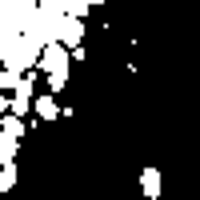

In [27]:
images[1]['bwImg'].resize((200,200))

In [28]:
fractionWhitSpace(images[1]['bwImg'])

0.2224

In [29]:

for i in range(10):
  threshold = (i+1) * 0.1
  num_img = len([img for img in images if fractionWhitSpace(img['bwImg']) > threshold]) 
  print('{0}({1}) of images have greater than {2}% whitespace'.format(num_img, 
                                                         num_img / len(images),
                                                         np.round(threshold*100, 1)))
  print('number of positive class {0}'.format(len([img for img in images if fractionWhitSpace(img['bwImg']) > threshold and img['class'] == '1'] )))
  print('number of negative class {0}'.format(len([img for img in images if fractionWhitSpace(img['bwImg']) > threshold and img['class'] == '0'] )))
  print()

170549(0.6145378417722431) of images have greater than 10.0% whitespace
number of positive class 25826
number of negative class 144723

139282(0.5018737118231216) of images have greater than 20.0% whitespace
number of positive class 17411
number of negative class 121871

117019(0.42165362274974416) of images have greater than 30.0% whitespace
number of positive class 12841
number of negative class 104178

97076(0.3497931710410631) of images have greater than 40.0% whitespace
number of positive class 9453
number of negative class 87623

77861(0.2805559158847523) of images have greater than 50.0% whitespace
number of positive class 6566
number of negative class 71295

58391(0.2103998212767184) of images have greater than 60.0% whitespace
number of positive class 4185
number of negative class 54206

38769(0.1396960262896182) of images have greater than 70.0% whitespace
number of positive class 2277
number of negative class 36492

19114(0.06887332266758911) of images have greater than 80.0

In [30]:
#remove images with more than 60% whitespace
threshold = 0.8

blnRemoveWhitespace = False
blnRemoveNonStandardShape = True

if blnRemoveWhitespace:
  filtered_images = [img for img in images if fractionWhitSpace(img['bwImg']) <= threshold and img['img'].size == (50,50)]
elif blnRemoveNonStandardShape:
  filtered_images = [img for img in images if img['img'].size == (50,50)]
else:
  filtered_images = images.copy()
print(len(filtered_images))

275222


















## Shuffle the list of lmages

In [31]:
#Make a copy of image list before shuffling so we dont' have to load the picked.
#This is so we don't have to load the picked file again 
shuffledImages =  filtered_images.copy()

np.random.seed(931)
np.random.shuffle(shuffledImages)

In [32]:
# show first 3 records
shuffledImages[0:3]

[{'bwImg': <PIL.Image.Image image mode=L size=50x50 at 0x7F7DB28B3EB8>,
  'class': '0',
  'file': '9227_idx5_x2401_y2101_class0.png',
  'id': '9227',
  'img': <PIL.Image.Image image mode=RGB size=50x50 at 0x7F7DCEABA240>,
  'x': 2401,
  'y': 2101},
 {'bwImg': <PIL.Image.Image image mode=L size=50x50 at 0x7F7DB6A29208>,
  'class': '1',
  'file': '12931_idx5_x1901_y1651_class1.png',
  'id': '12931',
  'img': <PIL.Image.Image image mode=RGB size=50x50 at 0x7F7DC24ED588>,
  'x': 1901,
  'y': 1651},
 {'bwImg': <PIL.Image.Image image mode=L size=50x50 at 0x7F7DB3C27780>,
  'class': '0',
  'file': '8918_idx5_x2051_y2401_class0.png',
  'id': '8918',
  'img': <PIL.Image.Image image mode=RGB size=50x50 at 0x7F7DCE950630>,
  'x': 2051,
  'y': 2401}]

## Get the image data (X) and labels (y)

In [33]:
n = len(images)
y = to_categorical([int(img['class']) for img in shuffledImages], num_classes = 2)[0:n]
y_label = [int(img['class']) for img in shuffledImages][0:n]


X = [img for img in shuffledImages][0:n]


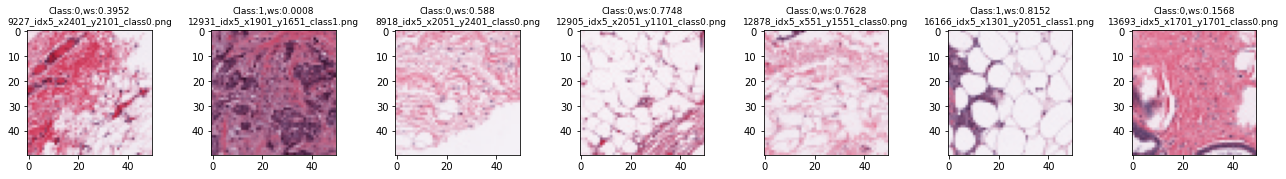

In [34]:

#visualize first few images
num_fig = 7

fig, axes = plt.subplots(1, num_fig, figsize=(18,18))

for i in range(num_fig):
  axes[i].set_title('Class:{0},ws:{1}\n{2}'.format(str(np.argmax(y[i])), fractionWhitSpace(X[i]['bwImg']), X[i]['file'] ), fontsize=9 )
  axes[i].imshow(X[i]['img'])

plt.tight_layout()

## Split Data in Train, Validation and Test

In [35]:
splitType = 'byImage'
train_split = 0.90
valid_split = 0.01

rnd_seed = 47


In [36]:
if splitType == 'byImage':

  X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=1-train_split, random_state=rnd_seed, shuffle=True)
  X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=1-valid_split, random_state=rnd_seed, shuffle=True)



In [37]:
#Split by IDs
if splitType == 'byID':
  ids = np.unique([img['id'] for img in images])

  rand = np.random.rand(len(ids))

  id_train, id_valid_test, id_train, id_valid_test = train_test_split(ids, ids, test_size=1-train_split, random_state=42, shuffle=True)
  id_valid, id_test, id_valid, id_test = train_test_split(id_valid_test, id_valid_test, test_size=1-valid_split, random_state=42, shuffle=True)

  idx_train = [idx for idx, x in enumerate(X) if x['id'] in id_train]
  idx_valid = [idx for idx, x in enumerate(X) if x['id'] in id_valid]
  idx_test = [idx for idx, x in enumerate(X) if x['id'] in id_test]

  X_train = [X[idx] for idx in idx_train]
  y_train = [y[idx] for idx in idx_train]


  X_valid = [X[idx] for idx in idx_valid]
  y_valid = [y[idx] for idx in idx_valid]


  X_test = [X[idx] for idx in idx_test]
  y_test = [y[idx] for idx in idx_test]




In [38]:
#fit the generator to get the mean and std of the dataset for standarization.
my_gen = image_label_generator()
my_gen.fit(X_train)  

print(my_gen.mean)
print(my_gen.std)

[0.7074272820593848, 0.6124843146738327, 0.8202489026901626]
[0.16746636409341067, 0.20791411904258664, 0.13076930413062712]


In [39]:
#show the data counts
show_split(y_train, y_valid, y_test)

Total count: 275222

train count: 247699 (0.90000)
train cancer count: 70836 (0.28598)
train non-cancer count: 176863 (0.71402)

valid count: 275 (0.00100)
valid cancer count: 69 (0.25091)
valid non-cancer count: 206 (0.74909)

test count: 27248 (0.09900)
test cancer count: 7863 (0.28857)
test non-cancer count: 19385 (0.71143)



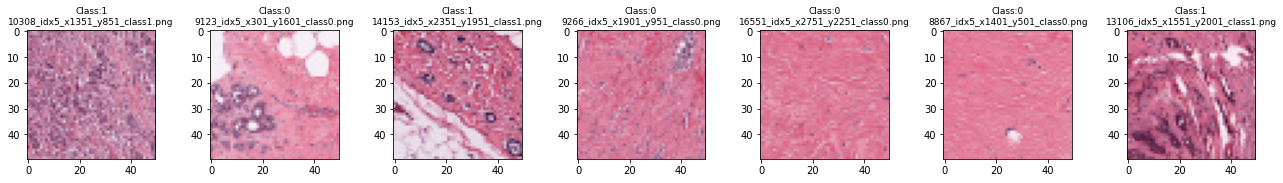

In [40]:
#visualize first few training images
num_fig = 7

fig, axes = plt.subplots(1, num_fig, figsize=(18,18))

for i in range(num_fig):
  axes[i].set_title('Class:{0}\n{1}'.format(str(np.argmax(y_train[i])), X_train[i]['file'] ), fontsize=9 )
  axes[i].imshow(X_train[i]['img'])

plt.tight_layout()

# Balance the training

In [41]:
balanceType = 'RandomOver'

## Random Ovesampling
Reference: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/


### Get all minority class images

In [42]:
blnLoad = False
shared_binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'

if balanceType == 'RandomOver':
  if blnLoad:
    X_train = pickle.load(open(binary_fldr + 'X_train_over.p', 'rb'))
    y_train = pickle.load(open(binary_fldr + 'y_train_over.p', 'rb'))
  
  else:  
    X_minority = [X_train[i] for i,y in enumerate(y_train) if np.argmax(y) == 1]
    y_minority = [y_train[i] for i,y in enumerate(y_train) if np.argmax(y) == 1]
    num_maj = len([y for y in y_train if y[0] == 1])
    num_min = len([y for y in y_train if y[0] == 0])

    X_rdm, y_rdm = getNRandom(X_minority, y_minority, num_maj - num_min)

    X_train_org = X_train.copy()
    y_train_org = y_train.copy()

    X_train = X_train + X_rdm
    y_train = np.insert(y_train, len(y_train), y_rdm, axis=0)

    # pickle.dump( X_train, open( shared_binary_fldr + 'X_train_over.p', "wb" ) )
    # pickle.dump( y_train, open( shared_binary_fldr + 'y_train_over.p', "wb" ) )

### Generate synthetic oversampling minority class

In [43]:

blnGenerate = False

shared_binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'

if balanceType == 'Smote':

  if blnGenerate:
    X_org, X_nb, X_gen = getNSynthetic_Annoy(X_minority, num_maj - num_min)

    pickle.dump( X_gen, open( shared_binary_fldr + 'X_gen_smote.p', "wb" ) )
    pickle.dump( X_org, open( shared_binary_fldr + 'X_org_smote.p', "wb" ) )
    pickle.dump( X_nb, open( shared_binary_fldr + 'X_nb_smote.p', "wb" ) )

  else:
    X_org = pickle.load(open(binary_fldr + 'X_org_smote.p', 'rb'))
    X_nb = pickle.load(open(binary_fldr + 'X_nb_smote.p', 'rb'))
    X_gen = pickle.load(open(binary_fldr + 'X_gen_smote.p', 'rb'))
    print('Load from binary') 

## Random Under sampling

In [44]:
blnLoad = False
shared_binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'

if balanceType == 'RandomUnder':
  if blnLoad:
    X_train = pickle.load(open(binary_fldr + 'X_train_under.p', 'rb'))
    y_train = pickle.load(open(binary_fldr + 'y_train_under.p', 'rb'))
  
  else:  
    X_minority = [X_train[i] for i,y in enumerate(y_train) if y[0] == 0]
    y_minority = [y_train[i] for i,y in enumerate(y_train) if y[0] == 0]

    X_majority = [X_train[i] for i,y in enumerate(y_train) if y[0] == 1]
    y_majority = [y_train[i] for i,y in enumerate(y_train) if y[0] == 1]

    num_maj = len([y for y in y_train if y[0] == 1])
    num_min = len([y for y in y_train if y[0] == 0])

    X_rdm, y_rdm = getNRandom(X_majority, y_majority, num_min)

    X_train_org = X_train.copy()
    y_train_org = y_train.copy()

    X_train = X_minority + X_rdm
    y_train = np.insert(y_minority, len(y_minority), y_rdm, axis=0)

    pickle.dump( X_train, open( shared_binary_fldr + 'X_train_under.p', "wb" ) )
    pickle.dump( y_train, open( shared_binary_fldr + 'y_train_under.p', "wb" ) )

## Visualize synthetic image

In [45]:
# numImages = 10

# fig, axes = plt.subplots(numImages, 3, figsize=(12,20))

# idx_list = np.random.randint(0,len(X_gen),numImages)

# for i, idx in enumerate(idx_list):

#   axes[i][0].set_title('Original', fontsize=9 )
#   axes[i][0].imshow(X_org[idx])

#   axes[i][1].set_title('Neighbour', fontsize=9 )
#   axes[i][1].imshow(X_nb[idx])

#   axes[i][2].set_title('Generated', fontsize=9 )
#   axes[i][2].imshow(X_gen[idx])
  
# plt.tight_layout()

## Simple replication  
Take all the positive classes and generate additional images by flipping them horizontally and vertically


In [46]:
# #get the list of positive images
# pos_idx = [i for i in range(len(y_train)) if y_train[i][1] == 1]

# # make copies by fliping some top/bottom and some left/right
# for i in pos_idx:
#   x = X_train[i].copy()
  
#   if i % 2 == 0:
#     x = x.transpose(Image.FLIP_TOP_BOTTOM)
#   else :
#     x = x.transpose(Image.FLIP_LEFT_RIGHT)
  
  
#   X_train.append(x)
#   #y_train.append(y_train[i])
#   y_train = np.insert(y_train, len(y_train),  y_train[i], axis=0)

## Append and Save Training for re-use




In [47]:

# blnLoadTrainSmote = True

# shared_binary_fldr = '/content/drive/Shared drives/Roger Chow/Dataset/IDC_regular_ps50_idx5_BIN/'
  
# if blnLoadTrainSmote:
#   X_train = pickle.load(open(binary_fldr + 'X_train_smote.p', 'rb'))
#   y_train = pickle.load(open(binary_fldr + 'y_train_smote.p', 'rb'))
# else:
#   X_train = X_train + X_gen

#   for i in range(len(X_gen)):
#     y_train = np.insert(y_train, len(y_train), y_minority[0], axis=0)

#   pickle.dump( X_train, open( shared_binary_fldr + 'X_train_smote.p', "wb" ) )
#   pickle.dump( y_train, open( shared_binary_fldr + 'y_train_smote.p', "wb" ) )



In [48]:
# reshuffle the data
X_train, y_train = randomize(X_train, y_train)


In [49]:
#show the data counts
show_split(y_train, y_valid, y_test)

Total count: 381249

train count: 353726 (0.92781)
train cancer count: 176863 (0.50000)
train non-cancer count: 176863 (0.50000)

valid count: 275 (0.00072)
valid cancer count: 69 (0.25091)
valid non-cancer count: 206 (0.74909)

test count: 27248 (0.07147)
test cancer count: 7863 (0.28857)
test non-cancer count: 19385 (0.71143)



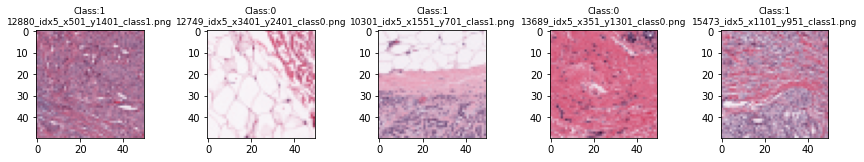

In [50]:
#visualize first few training images
num_fig = 5

fig, axes = plt.subplots(1, num_fig, figsize=(12,12))

for i in range(num_fig):
  axes[i].set_title('Class:{0}\n{1}'.format(str(np.argmax(y_train[i])), X_train[i]['file'] ), fontsize=9 )
  axes[i].imshow(X_train[i]['img'])

plt.tight_layout()

# Set up image generators

## Setup Image Data Generator for Data augmentation

In [51]:
dataGen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             horizontal_flip=True,
                             vertical_flip=True,
                             #rotation_range=45,
                             height_shift_range=0.0,
                             width_shift_range=0.0, 
                             shear_range=0,
                             fill_mode='wrap', 
                             #brightness_range = [0.8, 1.1],
                             #zca_whitening=True,
                             cval=255,
                             )

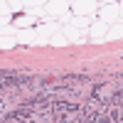

In [52]:
X_train[2]['img'].resize((123,123))

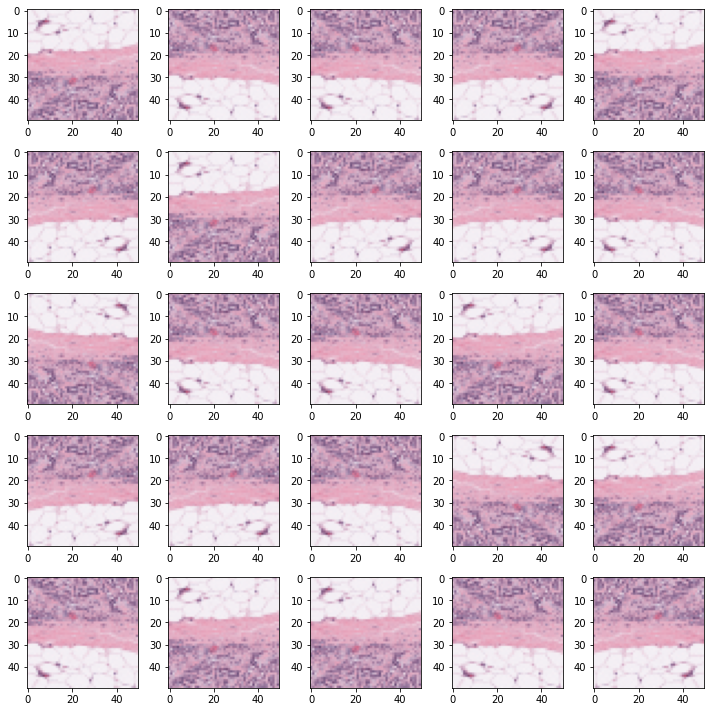

In [53]:
orig_rgb_img = pad(np.asarray(X_train[2]['img']), (50,50,3), 255)

num_fig = 5

fig, axes = plt.subplots(num_fig, num_fig, figsize=(10,10))

for i in range(num_fig**2):
  
  col = i % num_fig
  row = int(i / num_fig) 

  params = dataGen.get_random_transform(orig_rgb_img.shape)
  rgb_img = dataGen.apply_transform(orig_rgb_img, params)
  rgb_img = dataGen.standardize(rgb_img)

  axes[row][col].imshow(Image.fromarray(rgb_img.astype('uint8'), 'RGB'))



plt.tight_layout()




## Use custom image generator

In [87]:

batch_size = 512
scale_factor = 50/50
pad_flg = True
pad_size = (50,50,3)
pad_value = 255

train_image_label_generator = my_gen.generator(X_train, y_train, batch_size, scale_factor, pad_flg, pad_size, pad_value, dataGen)
#train_image_label_generator = image_label_generator(X_train, y_train, batch_size, scale_factor, pad_flg, pad_size, pad_value) #no data augmentation
valid_image_label_generator = my_gen.generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)
test_image_label_generator = my_gen.generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

train_size = len(y_train)
valid_size = len(y_valid)
test_size = len(y_test)

train_steps = int(np.ceil(train_size/batch_size))
valid_steps = int(np.ceil(valid_size/batch_size))
test_steps = int(np.ceil(test_size/batch_size))

In [55]:
mn = my_gen.mean
mn

[0.7074272820593848, 0.6124843146738327, 0.8202489026901626]

In [56]:
std = my_gen.std
std

[0.16746636409341067, 0.20791411904258664, 0.13076930413062712]

In [57]:
# ims = [images[i]['img'] for i in range(100)]

# rgb_img = np.asarray(ims[0])

# #rescale
# rgb_img2 = rgb_img / 255

# #standardize
# for ch in range(3):
#   rgb_img2[ch] = (rgb_img2[ch] - mn[ch]) / std[ch]

In [58]:
# rgb_img[2]/ 255

In [59]:
# rgb_img2[2]

# Model


## Model 1 - Simple Architecuture

In [60]:
blnSimpleModel = False

### Setup different architecture


















































































































Setting up simple Architecture 3 Convolution Layers with different number of filters.  The number of hidden units in the fully connected layers is equal to the number of filters


In [61]:
#layer wrapper

# function for creating ResNet module
def ResNet_Module(input_layer, n_filters):
  # first convolution layer with input from prevous layer (layer_in)
	conv1 = layers.Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
  # second convolution layer witn input from first convolution layer 
	conv2 = layers.Conv2D(n_filters, kernel_size=(3,3), activation='linear', padding='same')(conv1)
  # add output of layer second convolution layer with the input layer of the module
	layer_out = layers.add([conv2, input_layer])
	# relu activation layer
	layer_out = layers.Activation('relu')(layer_out)

	return layer_out

def Conv2D(input_layer, filters, kernel_size, strides=(1,1), activation='relu', padding='same'):
    return layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation, kernel_regularizer=regularizers.l2(0.001))(input_layer)

def Dropout(input_layer, rate) :
    return layers.Dropout(rate=rate)(x)

def AveragePooling(input_layer, pool_size=(2,2), stride=None, padding='valid'):
    return layers.AveragePooling2D(pool_size=pool_size, strides=stride, padding=padding)(input_layer)

def MaxPooling2D(input_layer, pool_size=(3,3), stride=None, padding='valid'):
    return layers.MaxPool2D(pool_size=pool_size, strides=stride, padding=padding)(input_layer)

def ConcatLayers(layer_list) :
    return layers.concat(layer_list, axis=3)

def Flatten(input_layer):
    return layers.Flatten()(input_layer)

def Dense(input_layer, units, activation='softmax'):
    return layers.Dense(units=units, activation=activation,kernel_regularizer=regularizers.l2(0.001))(input_layer)

def Dropout(input_layer, rate=0.5):
    return layers.Dropout(rate=rate)(input_layer)


def model_filter256(input_shape):
    filters = 256

    model = models.Sequential()
    model.add(layers.Conv2D(filters, (10,10), activation='relu', input_shape=input_shape,kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))
    model.add(layers.Conv2D(filters, kernel_size=(5,5), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))
    model.add(layers.Conv2D(filters, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))
    model.add(layers.Conv2D(filters, kernel_size=(2,2), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))
    model.add(layers.Flatten())
    model.add(layers.Dense(filters, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(2, activation='softmax',kernel_regularizer=regularizers.l2(0.001)))

    return model


def model_1(input_shape):
  input_img = layers.Input(input_shape)
  x = Conv2D(input_img, 64, (10,10), padding='valid')
  x = MaxPooling2D(x)
  x = Conv2D(x, 128, (5,5), padding='valid')
  x = MaxPooling2D(x)
  x = Conv2D(x, 256, (2,2), padding='valid')
  x = MaxPooling2D(x, pool_size=(2,2))
  x = Flatten(x)
  output = Dense(x, 2) 
  
  model = models.Model([input_img], output) 
  
  return model


def model_2(input_shape):
  input_img = layers.Input(input_shape)
  x = Conv2D(input_img, 64, (10,10), padding='valid')
  x = MaxPooling2D(x)
  x = Conv2D(input_img, 128, (10,10), padding='valid')
  x = MaxPooling2D(x)
  x = ResNet_Module(x, 128)
  x = MaxPooling2D(x, pool_size=(2,2))
  x = Flatten(x)
  output = Dense(x, 2)
  
  model = models.Model([input_img], output) 
    
  return model



def model_2b(input_shape):
  input_img = layers.Input(input_shape)
  x = Conv2D(input_img, 64, (10,10), padding='valid')
  x = MaxPooling2D(x)
  x = Conv2D(input_img, 128, (10,10), padding='valid')
  x = MaxPooling2D(x)
  x = ResNet_Module(x, 128)
  x = MaxPooling2D(x, pool_size=(2,2))
  x = Dropout(x, rate=0.5)
  x = Flatten(x)
  output = Dense(x, 2)
  
  model = models.Model([input_img], output) 
    
  return model


def model_3b(input_shape):
  input_img = layers.Input(input_shape)
  x = Conv2D(input_img, 128, (10,10), padding='valid')
  x = MaxPooling2D(x)
  x = ResNet_Module(x, 128)
  x = MaxPooling2D(x)
  x = ResNet_Module(x, 128)
  x = MaxPooling2D(x, pool_size=(2,2))
  x = Flatten(x)
  x = Dropout(x, rate=0.5)
  x = Dense(x, 512, activation='relu')

  output = Dense(x, 2)
  
  model = models.Model([input_img], output) 
    
  return model


def model_3(input_shape):
  input_img = layers.Input(input_shape)
  x = Conv2D(input_img, 64, (10,10), padding='valid')
  x = MaxPooling2D(x)
  x = Conv2D(input_img, 128, (10,10), padding='valid')
  x = MaxPooling2D(x)
  x = ResNet_Module(x, 128)
  x = MaxPooling2D(x)
  x = ResNet_Module(x, 128)
  x = MaxPooling2D(x, pool_size=(2,2))
  x = Flatten(x)
  x = Dropout(x, rate=0.5)
  x = Dense(x, 512, activation='relu')

  output = Dense(x, 2)
  
  model = models.Model([input_img], output) 
    
  return model



def model_4(input_shape):
  input_img = layers.Input(input_shape)
  x = Conv2D(input_img, 128, (10,10), padding='valid')
  x = MaxPooling2D(x, padding='same')
  x = ResNet_Module(x, 128)
  x = MaxPooling2D(x, padding='same')
  x = ResNet_Module(x, 128)
  x = MaxPooling2D(x, padding='same')
  x = ResNet_Module(x, 128)
  x = MaxPooling2D(x, pool_size=(2,2), padding='same')
  x = Flatten(x)
  x = Dropout(x, rate=0.5)
  x = Dense(x, 512, activation='relu')

  output = Dense(x, 2)
  
  model = models.Model([input_img], output) 
    
  return model

def model_reza(input_shape):
  input_img = layers.Input(input_shape)
  x = Conv2D(input_img, 32, (3,3), padding='valid' )
  x = Conv2D(x, 64, (3,3), padding='valid')
  x = MaxPooling2D(x)
  x=  Flatten(x)
  x = Dropout(x, rate=0.5)
  x = Dense(x, 128, activation='relu')
  x = Dropout(x, rate=0.25)
  output = Dense(x, 2, activation='softmax')
  model = models.Model([input_img], output) 
 
  return model



def model1(input_shape):
  model = models.Sequential()
  model.add(layers.Conv2D(64, (10,10), activation='relu', input_shape=(50,50,3),kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(3,3), padding='valid'))
  model.add(layers.Conv2D(128, kernel_size=(5,5), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(3,3), padding='valid'))
  model.add(layers.Conv2D(256, kernel_size=(2,2), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D(pool_size=(2,2), padding='valid'))
  model.add(layers.Dropout(rate=0.25))

  model.add(layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Dense(2, activation='softmax',kernel_regularizer=regularizers.l2(0.001)))
  return model



#reference https://maelfabien.github.io/deeplearning/inception/#in-keras
def model2(input_shape):
  input_img = layers.Input(input_shape)

  ### 1st layer
  layer_1 = layers.Conv2D(10, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_img)
  layer_1 = layers.Conv2D(10, (3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.001))(layer_1)

  layer_2 = layers.Conv2D(10, (1,1), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.001))(input_img)
  layer_2 = layers.Conv2D(10, (5,5), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.001))(layer_2)

  layer_3 = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
  layer_3 = layers.Conv2D(10, (1,1), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.001))(layer_3)

  mid_1 = layers.concatenate([layer_1, layer_2, layer_3], axis = 3)

  flat_1 = layers.Flatten()(mid_1)

  dense_1 = layers.Dense(1200, activation='relu',kernel_regularizer=regularizers.l2(0.001))(flat_1)
  dense_2 = layers.Dense(600, activation='relu',kernel_regularizer=regularizers.l2(0.001))(dense_1)
  dense_3 = layers.Dense(150, activation='relu',kernel_regularizer=regularizers.l2(0.001))(dense_2)
  output = layers.Dense(2, activation='softmax',kernel_regularizer=regularizers.l2(0.001))(dense_3)

  model = models.Model([input_img], output)
  return model



In [62]:
input_shape = (50,50,3)

model_list = []
model_list.append({'model':model_4(input_shape), 'description': 'model_4'} )


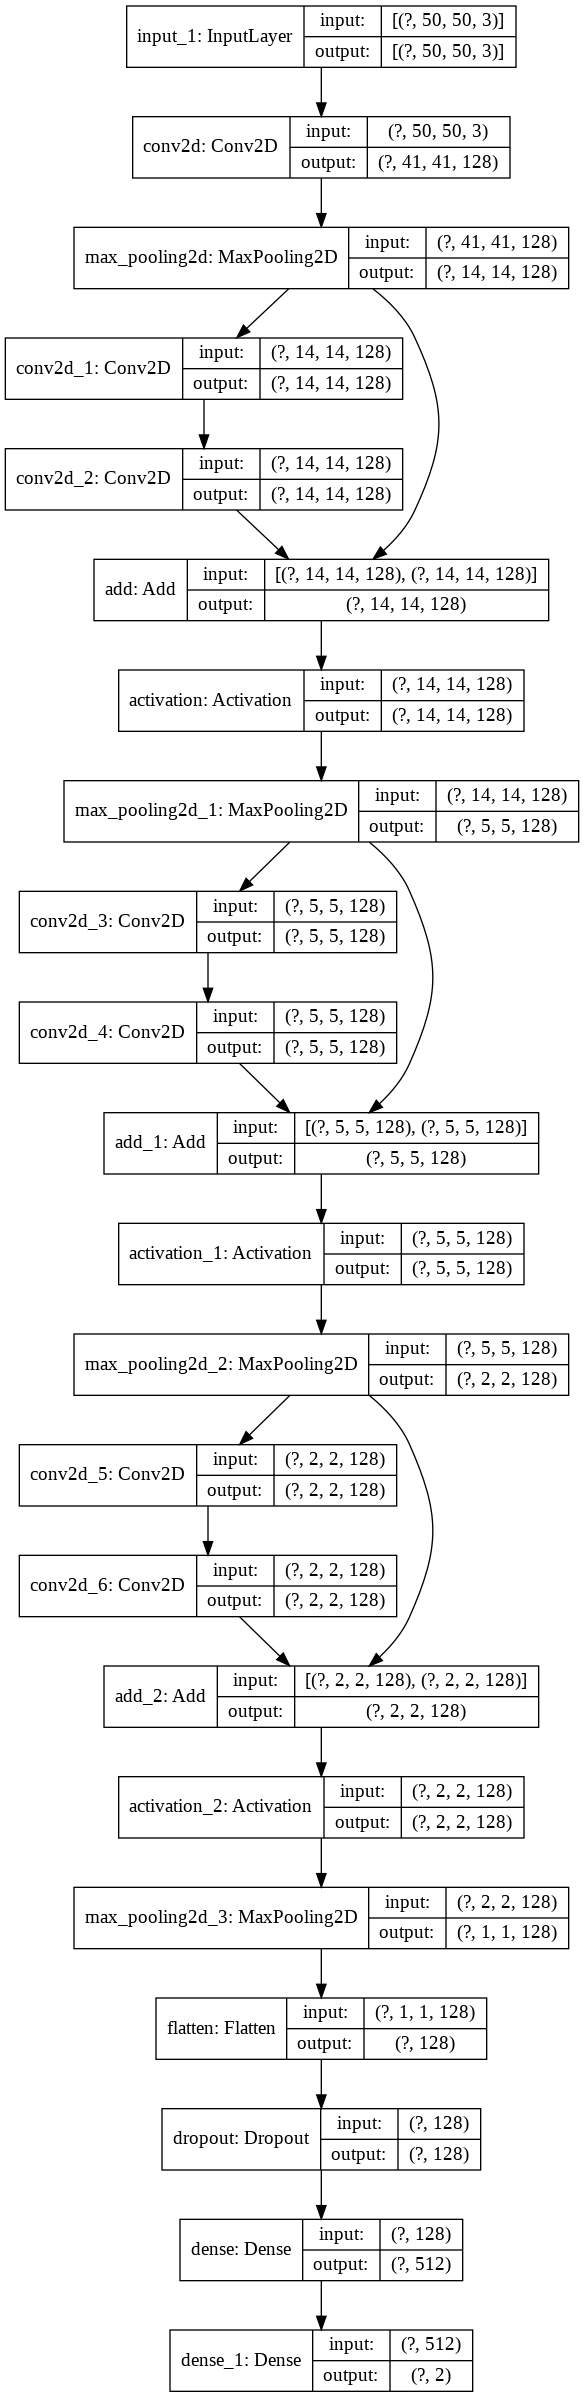

In [63]:
plot_model(model_list[0]['model'], show_shapes=True)


### Training

Training with 50 epoch without early stopping on each model

In [64]:
if blnSimpleModel:

  hist_list = []

  num_epoch = 25

  earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30,  verbose=True, restore_best_weights=True)
  clr_triangular = CyclicLR(mode='triangular2', base_lr=1e-5, max_lr=1e-3, step_size=int(train_steps*4))

  shared_model_fldr = '/content/drive/Shared drives/Roger Chow/Model/'

  for m in model_list:
    print('training model:{0}'.format(m['description']))

    adam = optimizers.Adam(learning_rate=1e-4, amsgrad=True)
    adadelta = optimizers.Adadelta(learning_rate=1e-3)
    m['model'].compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=["accuracy", "AUC", 
                                                                                       tf.keras.metrics.Recall(class_id = 0, name='recall_0', thresholds=0.5), 
                                                                                       tf.keras.metrics.Recall(class_id = 1, name='recall_1'),
                                                                                       tf.keras.metrics.Precision(class_id=0, name='precision_0'),
                                                                                       tf.keras.metrics.Precision(class_id=1, name='precision_1')])
  

    m['model'].summary()
    hist =  m['model'].fit(x=train_image_label_generator, epochs=num_epoch,  steps_per_epoch = train_steps, callbacks=[clr_triangular],
                    validation_data=valid_image_label_generator, validation_steps = valid_steps, verbose=1)

    m['hist'] = hist.history

    #save the model
    m['model'].save(shared_model_fldr +  m['description']+ '_' + balanceType)

    #save hist
    pickle.dump(m['hist'] , open( shared_model_fldr + m['description'] + '_' + balanceType + '_hist.p', "wb" ) )




### Evaluation

In [65]:
if blnSimpleModel:

  for m in model_list:

    scores =  m['model'].evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
    m['score'] = scores

  m['score']

### Performance curves

In [66]:
if blnSimpleModel:
  for m in model_list:
    plot_performance(m['hist'], m['description'])

### Confusion Matrix and Balanced Accuracy with threshold 0.5



In [67]:
if blnSimpleModel:

  cutoff = 0.5

  map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

  #reset test image generator
  for m in model_list:
    test_image_label_generator = my_gen.generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

    y_pred = m['model'].predict(x=test_image_label_generator, batch_size=None, verbose=0, steps=test_steps)

    # valid_image_label_generator = image_label_generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)

    # y_pred = m['model'].predict(x=valid_image_label_generator, batch_size=None, verbose=0, steps=valid_steps)
    

    y_pred = np.asarray([(lambda x: 1 if x[1] >= cutoff else 0)(x) for x in y_pred])
    y_true = np.argmax(y_test,axis = 1) 
    confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

    m['confusion_mtx'] = confusion_mtx
    m['y_pred'] = y_pred
    m['y_true'] = y_true
      
    m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)
    m['score_f1'] = metrics.f1_score(y_true, y_pred)
    m['score_recall'] = metrics.recall_score(y_true, y_pred)
    m['score_precision'] = metrics.precision_score(y_true, y_pred)
    
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=False)

    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']))


### Compare Models orderd by BAC

In [68]:
if blnSimpleModel:

  # Comparison of all models

  modelName = [m['description'] for m in model_list ]
  modelBAC = [m['balanced_acc'] for m in model_list ]
  modelLoss = [m['score'][0] for m in model_list ]
  modelAccuracy = [m['score'][1] for m in model_list ]
  modelAUC = [m['score'][2] for m in model_list ]
  modelF1 = [m['score_f1'] for m in model_list ]
  modelRecall = [m['score_recall'] for m in model_list ]
  modelPrecision = [m['score_precision'] for m in model_list ]

  df = pd.DataFrame({'model':modelName, 'loss': modelLoss,'bac':modelBAC, 'accuracy':modelAccuracy,'f1':modelF1, 'recall':modelRecall, 'precision':modelPrecision})
  df = df.sort_values('bac', ascending=False)

  df

In [69]:
if blnSimpleModel:
  df

### Confusion Matrix and Balanced Accuracy with threshold 0.55



In [70]:
if blnSimpleModel:

  cutoff = 0.55

  map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

  #reset test image generator
  for m in model_list:
    test_image_label_generator = my_gen.generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

    y_pred = m['model'].predict(x=test_image_label_generator, batch_size=None, verbose=0, steps=test_steps)

    # valid_image_label_generator = image_label_generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)

    # y_pred = m['model'].predict(x=valid_image_label_generator, batch_size=None, verbose=0, steps=valid_steps)
    

    y_pred = np.asarray([(lambda x: 1 if x[1] >= cutoff else 0)(x) for x in y_pred])
    y_true = np.argmax(y_test,axis = 1) 
    confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

    m['confusion_mtx'] = confusion_mtx
    m['y_pred'] = y_pred
    m['y_true'] = y_true
      
    m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)
    m['score_f1'] = metrics.f1_score(y_true, y_pred, )
    m['score_recall'] = metrics.recall_score(y_true, y_pred)
    m['score_precision'] = metrics.precision_score(y_true, y_pred)
    
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=False)

    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']))


In [71]:
if blnSimpleModel:

  # Comparison of all models

  modelName = [m['description'] for m in model_list ]
  modelBAC = [m['balanced_acc'] for m in model_list ]
  modelLoss = [m['score'][0] for m in model_list ]
  modelAccuracy = [m['score'][1] for m in model_list ]
  modelAUC = [m['score'][2] for m in model_list ]
  modelF1 = [m['score_f1'] for m in model_list ]
  modelRecall = [m['score_recall'] for m in model_list ]
  modelPrecision = [m['score_precision'] for m in model_list ]

  df = pd.DataFrame({'model':modelName, 'loss': modelLoss,'bac':modelBAC, 'accuracy':modelAccuracy,'f1':modelF1, 'recall':modelRecall, 'precision':modelPrecision})
  df = df.sort_values('bac', ascending=False)


In [72]:
if blnSimpleModel:
  df

### Look at ones wrongly predicted from Validation


In [73]:
if blnSimpleModel:

  map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

  #reset test image generator
  for m in model_list:
    valid_image_label_generator = my_gen.generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)

    y_pred = m['model'].predict(x=valid_image_label_generator, batch_size=None, verbose=0, steps=valid_steps)

    y_pred = np.argmax(y_pred,axis = 1) 
    y_true = np.argmax(y_valid,axis = 1) 
    confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

    m['confusion_mtx'] = confusion_mtx
    m['y_pred'] = y_pred
    m['y_true'] = y_true
      
    m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)

    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=False)

    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=True)

In [74]:
if blnSimpleModel:

  idx_fp = [i for i in range(len(y_pred)) if y_pred[i] != y_true[i] and y_pred[i] == 1]
  idx_fn = [i for i in range(len(y_pred)) if y_pred[i] != y_true[i] and y_pred[i] == 0]

  idx_tp = [i for i in range(len(y_pred)) if y_pred[i] == y_true[i] and y_pred[i] == 1]
  idx_tn = [i for i in range(len(y_pred)) if y_pred[i] == y_true[i] and y_pred[i] == 0]



In [75]:
if blnSimpleModel:

  #add a attribute for predicted class
  for i in range(len(X_valid)):
    X_valid[i]['pred_class'] =  y_pred[i]



In [76]:

def viewImages(X, idx, num_fig=5):
  num_fig = num_fig

  fig, axes = plt.subplots(num_fig, num_fig, figsize=(num_fig*2,num_fig*2))

  for i in range(num_fig*num_fig):
    
    col = i % num_fig
    row = int(i / num_fig) 

    img = X[idx[i]]['img']
    axes[row][col].set_title(X[idx[i]]['file'], fontsize=7 )
    axes[row][col].imshow(img)
    axes[row][col].axis('off')

  plt.tight_layout()

In [77]:
if blnSimpleModel:
  
  #false positive
  viewImages(X_valid, idx_fp, 5)

In [78]:
if blnSimpleModel:

  #false negative
  viewImages(X_valid, idx_fn, 5)

In [79]:
if blnSimpleModel:

  #true positive
  viewImages(X_valid, idx_tp, 5)

In [80]:
if blnSimpleModel:

  #true negative
  viewImages(X_valid, idx_tn, 5)

In [81]:
def viewPrediction(id, scale = 0.25, X=X_valid, images=images):
  border_width = 4

  a_list = [img for img in images if img['id'] == id] 
  x_list = [img for img in X if img['id'] == id] 

  min_x = min([img['x'] for img in a_list])
  max_x = max([img['x'] for img in a_list])
  min_y = min([img['y'] for img in a_list])
  max_y = max([img['y'] for img in a_list])

  patch_size = 50

  total_width = (max_x - min_x + 50)
  total_height = (max_y - min_y + 50)

  new_im = Image.new('RGB', (total_width, total_height), color=(255, 255, 255))


  for img in a_list:
    base_img = img['img']
    if img['class'] == '1':
      class_img = Image.new('RGB', base_img.size, color=(0,255,0))
      mask = Image.new("L", base_img.size, 200)
      im = Image.composite(base_img, class_img, mask)
    else:
      class_img = Image.new('RGB', base_img.size, color=(255,255,255))
      mask = Image.new("L", base_img.size, 255)
      im = base_img #Image.composite(img['img'], class_img, mask)

    bimg =  ImageOps.crop(im, border=border_width)
    bimg = ImageOps.expand(bimg, border=(border_width, border_width), fill=(180,180,180))
    
    new_im.paste(bimg, (img['x'] - min_x ,img['y']-min_y))


  for img in a_list:

    if img['class'] == '1':
      class_img = Image.new('RGB', img['img'].size, color=(0,255,0))
      mask = Image.new("L", img['img'].size, 180)
      im = Image.composite(img['img'], class_img, mask)
    else:
      class_img = Image.new('RGB', img['img'].size, color=(255,255,255))
      mask = Image.new("L", img['img'].size, 255)
      im = Image.composite(img['img'], class_img, mask)

    
    #get the validation obj
    val_obj = [x for x in x_list if x['file'] == img['file']]
    if len(val_obj) > 0:
      val_obj = val_obj[0]
      
      bimg =  ImageOps.crop(im, border=border_width)
      if str(val_obj['pred_class']) == img['class']:
        bimg = ImageOps.expand(bimg, border=(border_width-1, border_width-1), fill=(0,255,0))
        
      elif str(val_obj['pred_class']) != img['class']:   #validation prediction incorrect
        bimg = ImageOps.expand(bimg, border=(border_width-1, border_width-1), fill=(255,0,0))  

      
      new_im.paste(bimg, (img['x'] - min_x ,img['y']-min_y))

  return new_im.resize((int(total_width*scale), int(total_height*scale))) 

In [82]:
if blnSimpleModel:
    
  ids = np.unique([img['id'] for img in images])

  for id in ids[0:10]:
    plt.figure(figsize=(20,20))
    plt.imshow(viewPrediction(id, images=filtered_images ))
    plt.title(id)
    

### Evaluate one slide


In [83]:




def evaluateModelByID(model, slideID):

  X_slide = [img for img in images  if img['id'] == slideID]
  y_slide = to_categorical([int(img['class']) for img in images if img['id'] == slideID] , num_classes = 2)

  slide_size = len(y_slide)
  slide_steps = int(np.ceil(slide_size/batch_size))

  slide_image_label_generator = my_gen.generator(X_slide, y_slide, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred_slide_prob = np.array(model.predict(x=slide_image_label_generator, batch_size=None, verbose=0, steps=slide_steps))

  y_pred_slide = np.argmax(y_pred_slide_prob,axis = 1) 
  y_true_slide = np.argmax(y_slide,axis = 1) 

    #add a attribute for predicted class
  for i in range(len(X_slide)):
    X_slide[i]['pred_class'] =  y_pred_slide[i]
    X_slide[i]['pred_prob_class'] =  y_pred_slide_prob[i]

  return X_slide


#reference: https://www.kaggle.com/allunia/breast-cancer
def getProbGrid(image_list, patch_size=50):
    
    min_x = min([img['x'] for img in image_list])
    max_x = max([img['x'] for img in image_list])
    min_y = min([img['y'] for img in image_list])
    max_y = max([img['y'] for img in image_list])

    total_width = (max_x - min_x + patch_size)
    total_height = (max_y - min_y + patch_size)

    max_point = [max_y-1, max_x-1]
    
    grid = np.zeros(shape = (max_point[0] + patch_size, max_point[1] + patch_size, 1)).astype(np.float)
    
    for n in range(len(image_list)):
      image = image_list[n]['img']
      target = image_list[n]['class']
      
      x_coord = image_list[n]['x']
      y_coord = image_list[n]['y']
      x_start = x_coord - 1
      y_start = y_coord - 1
      x_end = x_start + 50
      y_end = y_start + 50

      # if 'pred_prob_class' in image_list:
      grid[y_start:y_end, x_start:x_end, 0] = np.float(image_list[n]['pred_prob_class'][1])
            
    return grid



def viewSlidePrediction(slideID, scale=0.25, images=images ):

  X_slide = [img for img in images  if img['id'] == slideID]
  y_slide = to_categorical([int(img['class']) for img in images if img['id'] == slideID] , num_classes = 2)

  slide_size = len(y_slide)
  slide_steps = int(np.ceil(slide_size/batch_size))

  slide_image_label_generator = my_gen.generator(X_slide, y_slide, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred_slide_prob = m['model'].predict(x=slide_image_label_generator, batch_size=None, verbose=0, steps=slide_steps)

  y_pred_slide = np.argmax(y_pred_slide_prob,axis = 1) 
  y_true_slide = np.argmax(y_slide,axis = 1) 

    #add a attribute for predicted class
  for i in range(len(X_slide)):
    X_slide[i]['pred_class'] =  y_pred_slide[i]
    X_slide[i]['pred_prob_class'] =  y_pred_slide_prob[i]

  print('bac:', metrics.balanced_accuracy_score(y_true_slide, y_pred_slide, sample_weight=None, adjusted=False))

  return viewPrediction(slideID,scale=scale, X=X_slide)



In [84]:

if blnSimpleModel:

  n = 10
  fig, ax = plt.subplots(n,2,figsize=(25,n*10))

  for i,slideID in enumerate(ids[0:n]):

    ax[i,0].imshow(viewSlide(images, slideID, border_width=0, scale=1), alpha=1)
    ax[i, 1].imshow(getProbGrid(evaluateModelByID(m['model'], slideID))[:,:,0], cmap="Greens")

    ax[i, 0].grid(False)
    ax[i, 1].grid(False)
    ax[i, 0].set_title("Slide ID with cancer region: " + slideID)
    ax[i, 1].set_title("Probability: " + slideID );

In [85]:
0

0

## Model 2 - Iconic Architectures



### Setup and training

In [88]:

tf_model_list = []
num_epoch = 50
input_shape = (50, 50, 3)

blnTrainDense = True
modelReza =model_reza(input_shape)
modelResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
modelResNet101 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
modelDenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
modelDenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
modelDenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)


#modelInceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

baseModels = [
              #{'name':'modelReza_norm' + '_' + balanceType, 'model':modelReza, 'input_shape':input_shape}

              # {'name':'ResNet50_norm' + '_' + balanceType, 'model':modelResNet50, 'input_shape':input_shape},
              #{'name':'ResNet101_norm' + '_' + balanceType, 'model':modelResNet101, 'input_shape':input_shape}
              #{'name':'DenseNet121_norm_drop' + '_' + balanceType, 'model':modelDenseNet121, 'input_shape':input_shape},         
              {'name':'DenseNet169_norm' + '_' + balanceType, 'model':modelDenseNet169, 'input_shape':input_shape},
              #{'name':'DenseNet201_norm'  + '_' + balanceType, 'model':modelDenseNet201, 'input_shape':input_shape}
              # #{'name':'InceptionResNetv2_norm', 'model':modelInceptionResNetV2, 'input_shape':input_shape}
              ] 


shared_model_fldr = '/content/drive/Shared drives/Roger Chow/Model/'

lr_finder = LRFinder(steps_per_epoch=train_steps, epochs=num_epoch)

for baseModel in baseModels:

  

  print('base:' + baseModel['name'])

  if blnTrainDense:

    # earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=1,  verbose=True, restore_best_weights=True)
    # clr_triangular = CyclicLR(mode='triangular2', base_lr=1e-4, max_lr=1e-3, step_size=int(train_steps*2))

    model = Sequential([baseModel['model'],
                        layers.Flatten(),
                        layers.Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
                        
                        ])


    earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25,  verbose=True, restore_best_weights=True)

    #only train last layer
    #model.layers[0].trainable = False

    #optimizer
    #sgd = optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)
    adam = optimizers.Adam(learning_rate=1e-4, amsgrad=True)
    clr_triangular = CyclicLR(mode='triangular2', base_lr=5e-6, max_lr=5e-4, step_size=int(train_steps*4), )
    #clr_triangular = CyclicLR(mode='exp_range', gamma=0.99, base_lr=5e-6, max_lr=5e-4, step_size=int(train_steps*num_epoch / 2))


    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam, metrics=["accuracy", "AUC", 
                                                                                       tf.keras.metrics.Recall(class_id = 0, name='recall_0', thresholds=0.5), 
                                                                                       tf.keras.metrics.Recall(class_id = 1, name='recall_1'),
                                                                                       tf.keras.metrics.Precision(class_id=0, name='precision_0'),
                                                                                       tf.keras.metrics.Precision(class_id=1, name='precision_1')])
    model.summary()

    #train model
    hist =  model.fit(x=train_image_label_generator, epochs=num_epoch,  steps_per_epoch = train_steps, callbacks=[clr_triangular, earlystop_callback],
                    validation_data=valid_image_label_generator, validation_steps = valid_steps, verbose=1)
    
    #store the model and history
    tf_model_list.append({'model':model, 'description': baseModel['name'], 'hist':hist.history, 'clr':clr_triangular})

    #save model
    model.save(shared_model_fldr + baseModel['name'])

    #save hist
    pickle.dump( hist.history, open( shared_model_fldr + baseModel['name'] + '_hist.p', "wb" ) )



  else:

    model = tf.keras.models.load_model(shared_model_fldr + baseModel['name'])
  
    history = pickle.load(open(shared_model_fldr + baseModel['name'] + '_hist.p', 'rb'))

    tf_model_list.append({'model':model, 'description': baseModel['name'], 'hist':history})
 

base:DenseNet169_norm_RandomOver
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1, 1, 1664)        12642880  
_________________________________________________________________
flatten_4 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 3330      
Total params: 12,646,210
Trainable params: 12,487,810
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/50
691/691 [==============================] - 170s 247ms/step - loss: 0.4229 - accuracy: 0.8283 - auc: 0.9056 - recall_0: 0.8276 - recall_1: 0.8289 - precision_0: 0.8287 - precision_1: 0.8278 - val_loss: 0.3329 - val_accuracy: 0.8618 - val_auc: 0.9399 - val_recall_0: 0.8544 - val_recall_1: 0.8841 - val_precision_0: 0.9565 -


### Evaulation


In [89]:
for m in tf_model_list:

  scores =  m['model'].evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
  m['score'] = scores
  

In [90]:
scores

[0.5585677027702332,
 0.9075161218643188,
 0.9426519274711609,
 0.9373226761817932,
 0.8340328335762024,
 0.9329910278320312,
 0.8436896800994873]

### Performance curves


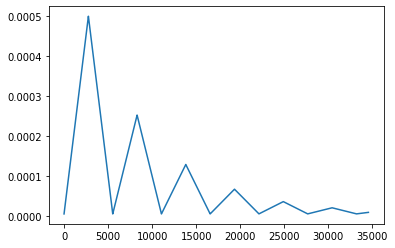

In [91]:

for m in tf_model_list:
  plt.plot(m['clr'].history['lr'])


In [92]:
# plt.scatter(clr_triangular.history['lr'], clr_triangular.history['loss'])

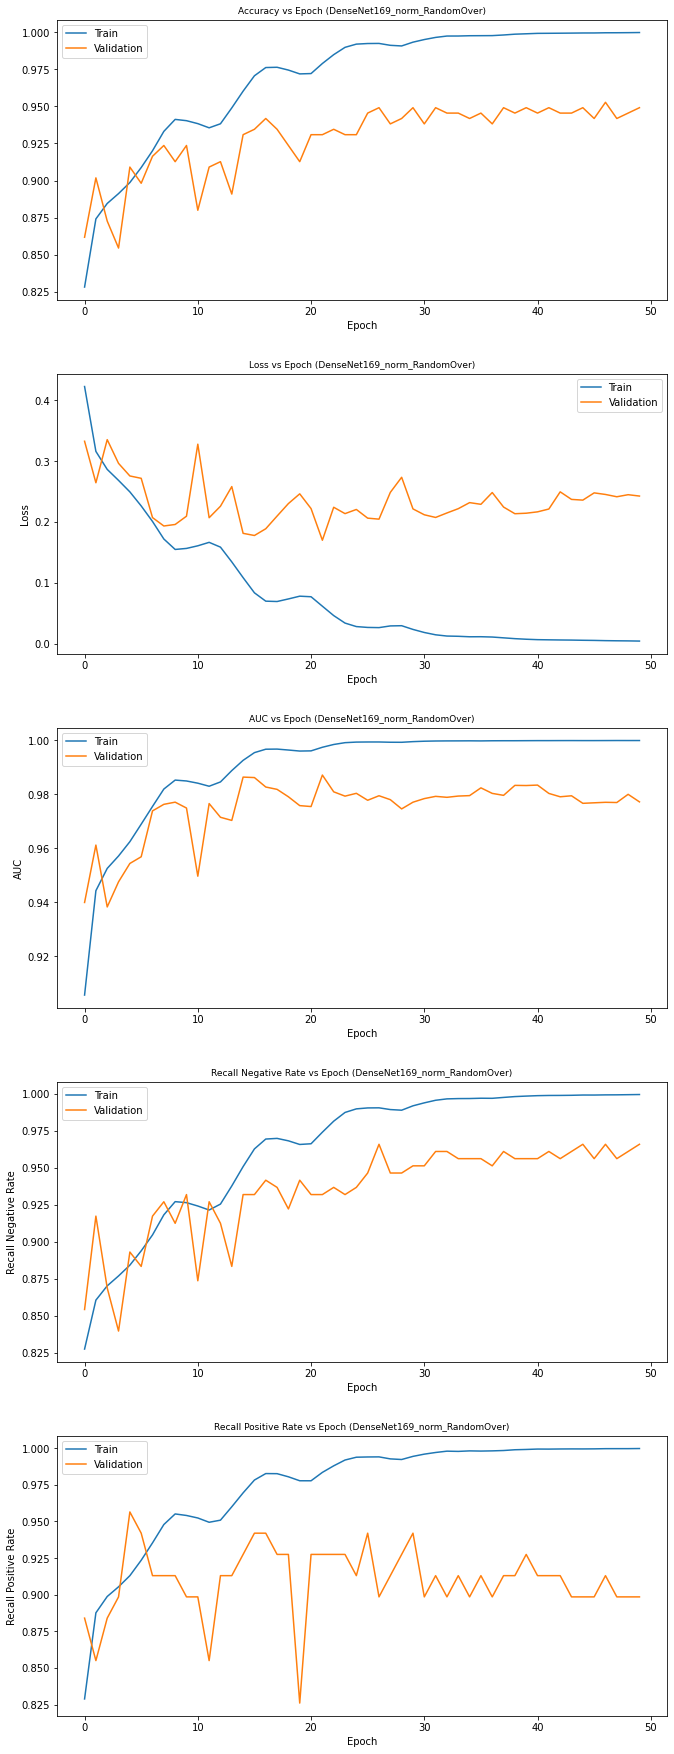

In [93]:
for m in tf_model_list:
  plot_performance(m['hist'], m['description'])

### Confusion Matrix (cutoff 0.5)


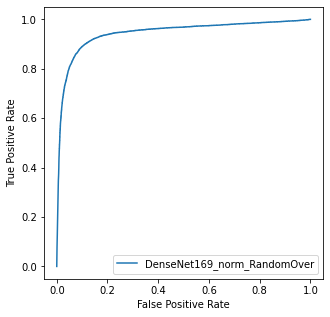

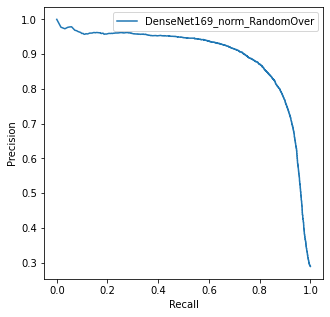

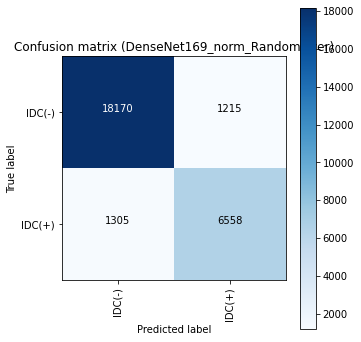

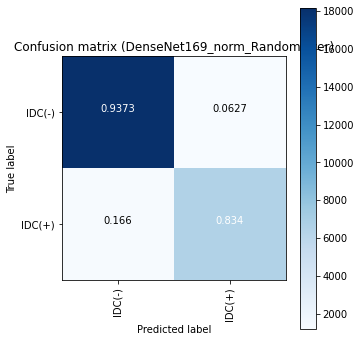

In [94]:
cutoff = 0.5
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

#reset test image generator
for m in tf_model_list:
  test_image_label_generator = my_gen.generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred_prob = m['model'].predict(x=test_image_label_generator, batch_size=None, verbose=0, steps=test_steps)

  y_pred = np.asarray([(lambda x: 1 if x[1] >= cutoff else 0)(x) for x in y_pred_prob])

  y_pred_prob = [x[1] for x in y_pred_prob]
  y_true = np.argmax(y_test,axis = 1) 

  # calculate roc curve for model
  fpr, tpr, _ = metrics.roc_curve(y_true, y_pred_prob)

  confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

  m['confusion_mtx'] = confusion_mtx
  m['y_pred_prob'] = y_pred_prob
  m['y_pred'] = y_pred
  m['y_true'] = y_true
    
  m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)
  m['score_f1'] = metrics.f1_score(y_true, y_pred)
  m['score_recall'] = metrics.recall_score(y_true, y_pred)
  m['score_precision'] = metrics.precision_score(y_true, y_pred)


  # calculate roc curve for model
  fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred_prob)
  plt.figure(figsize=(5,5))
  plt.plot(fpr, tpr, label=m['description'])
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

  # calculate precision recall
  precision, recall, threshold = metrics.precision_recall_curve(y_true, y_pred_prob)
  
  # plot the model precision-recall curve
  plt.figure(figsize=(5,5))
  plt.plot(recall, precision,  label=m['description'])
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=True)


### Compare Models order by BAC

In [95]:
  modelName = [m['description'] for m in tf_model_list ]
  modelBAC = [m['balanced_acc'] for m in tf_model_list ]
  modelLoss = [m['score'][0] for m in tf_model_list ]
  modelAccuracy = [m['score'][1] for m in tf_model_list ]
  modelAUC = [m['score'][2] for m in tf_model_list ]
  modelF1 = [m['score_f1'] for m in tf_model_list ]
  modelRecall = [m['score_recall'] for m in tf_model_list ]
  modelPrecision = [m['score_precision'] for m in tf_model_list ]

  df = pd.DataFrame({'model':modelName, 'loss': modelLoss,'bac':modelBAC, 'accuracy':modelAccuracy,'f1':modelF1, 'recall':modelRecall, 'precision':modelPrecision, 'AUC':modelAUC})
  df = df.sort_values('bac', ascending=False)

df

,model,loss,bac,accuracy,f1,recall,precision,AUC
0,DenseNet169_norm_RandomOver,0.558568,0.885678,0.907516,0.838833,0.834033,0.84369,0.942652


### Confusion Matrix (cutoff 0.6)

In [ ]:
cutoff = 0.6
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

#reset test image generator
for m in tf_model_list:
  test_image_label_generator = my_gen.generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred = m['model'].predict(x=test_image_label_generator, batch_size=None, verbose=0, steps=test_steps)

  y_pred = np.asarray([(lambda x: 1 if x[1] >= cutoff else 0)(x) for x in y_pred])
  y_true = np.argmax(y_test,axis = 1) 
  confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

  m['confusion_mtx'] = confusion_mtx
  m['y_pred'] = y_pred
  m['y_true'] = y_true
    
  m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)
  m['score_f1'] = metrics.f1_score(y_true, y_pred)
  m['score_recall'] = metrics.recall_score(y_true, y_pred)
  m['score_precision'] = metrics.precision_score(y_true, y_pred)


  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=True)

### Compare Models order by BAC

In [ ]:
modelName = [m['description'] for m in tf_model_list ]
modelBAC = [m['balanced_acc'] for m in tf_model_list ]
modelLoss = [m['score'][0] for m in tf_model_list ]
modelAccuracy = [m['score'][1] for m in tf_model_list ]
modelAUC = [m['score'][2] for m in tf_model_list ]
modelF1 = [m['score_f1'] for m in tf_model_list ]
modelRecall = [m['score_recall'] for m in tf_model_list ]
modelPrecision = [m['score_precision'] for m in tf_model_list ]

df = pd.DataFrame({'model':modelName, 'loss': modelLoss,'bac':modelBAC, 'accuracy':modelAccuracy,'f1':modelF1, 'recall':modelRecall, 'precision':modelPrecision, 'AUC':modelAUC})
df = df.sort_values('bac', ascending=False)
df

### Look at ones wrongly predicted from Validation


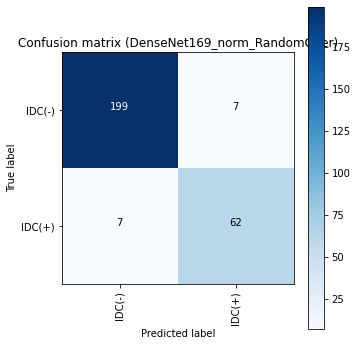

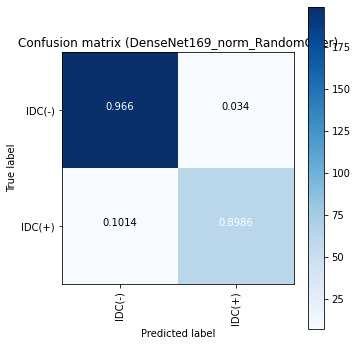

In [96]:
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

#reset test image generator
for m in tf_model_list:
  valid_image_label_generator = my_gen.generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred = m['model'].predict(x=valid_image_label_generator, batch_size=None, verbose=0, steps=valid_steps)

  y_pred = np.argmax(y_pred,axis = 1) 
  y_true = np.argmax(y_valid,axis = 1) 
  confusion_mtx = metrics.confusion_matrix(y_true, y_pred)

  m['confusion_mtx'] = confusion_mtx
  m['y_pred'] = y_pred
  m['y_true'] = y_true
    
  m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=False)

  plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()), title='Confusion matrix ({0})'.format(m['description']), normalize=True)

In [97]:
idx_fp = [i for i in range(len(y_pred)) if y_pred[i] != y_true[i] and y_pred[i] == 1]
idx_fn = [i for i in range(len(y_pred)) if y_pred[i] != y_true[i] and y_pred[i] == 0]

idx_tp = [i for i in range(len(y_pred)) if y_pred[i] == y_true[i] and y_pred[i] == 1]
idx_tn = [i for i in range(len(y_pred)) if y_pred[i] == y_true[i] and y_pred[i] == 0]



In [98]:
#add a attribute for predicted class
for i in range(len(X_valid)):
  X_valid[i]['pred_class'] =  y_pred[i]



In [99]:

def viewImages(X, idx, num_fig=5):
  num_fig = num_fig

  fig, axes = plt.subplots(num_fig, num_fig, figsize=(num_fig*2,num_fig*2))

  for i in range(num_fig*num_fig):
    
    col = i % num_fig
    row = int(i / num_fig) 

    img = X[idx[i]]['img']
    axes[row][col].set_title(X[idx[i]]['file'], fontsize=7 )
    axes[row][col].imshow(img)
    axes[row][col].axis('off')

  plt.tight_layout()

IndexError: ignored

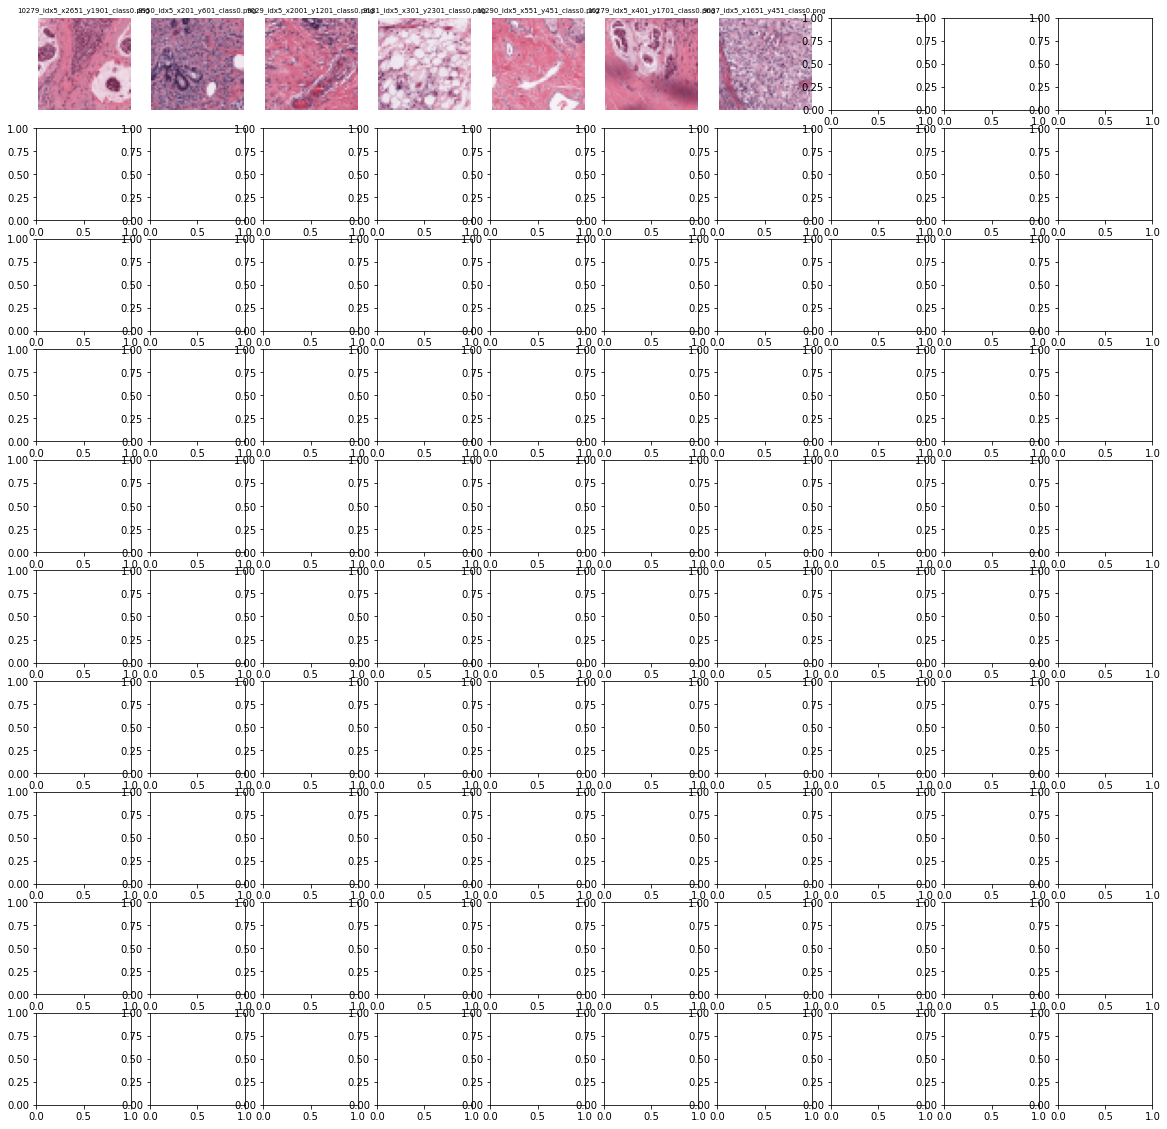

In [100]:
#false positive
viewImages(X_valid, idx_fp, 10)

In [ ]:
#false negative
viewImages(X_valid, idx_fn, 10)

In [ ]:
#true positive
viewImages(X_valid, idx_tp, 10)

### Evaluate single slide

In [ ]:



n = 10
fig, ax = plt.subplots(n,2,figsize=(25,n*10))

for i,slideID in enumerate(ids[0:n]):

  ax[i,0].imshow(viewSlide(images, slideID, border_width=0, scale=1), alpha=1)
  ax[i, 1].imshow(getProbGrid(evaluateModelByID(m['model'], slideID))[:,:,0], cmap="Greens")

  ax[i, 0].grid(False)
  ax[i, 1].grid(False)
  ax[i, 0].set_title("Slide ID with cancer region: " + slideID)
  ax[i, 1].set_title("Probability: " + slideID );

# Cross Validation (TO DO)
reference: https://machinelearningmastery.com/k-fold-cross-validation/

Cross validation is used to estimate the perfomance of a model on unseen data to give confidence that a final model trained on ALL data will be valid.

All models trained in cross validation are discarded.  Only the evaluation score is retained for summary

## Setup stratifed K-Folds
reference: https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/



In [ ]:
# #model 1
# def simple_seq_model(numFilters): 
#   model = models.Sequential()
#   model.add(layers.Conv2D(numFilters, (3,3), activation='relu', input_shape=(50,50,3),kernel_regularizer=regularizers.l2(0.001)))
#   model.add(layers.MaxPooling2D(pool_size=(2,2)))
#   model.add(layers.Conv2D(numFilters, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
#   model.add(layers.MaxPooling2D(pool_size=(2,2)))
#   model.add(layers.Conv2D(numFilters, kernel_size=(3,3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
#   model.add(layers.MaxPooling2D(pool_size=(2,2)))
#   model.add(layers.Flatten())
#   model.add(layers.Dense(numFilters, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
#   model.add(layers.Dense(2, activation='softmax',kernel_regularizer=regularizers.l2(0.001)))

#   model.summary()

#   adam = optimizers.Adam(learning_rate=1e-4, amsgrad=True)
#   model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy', 'AUC'])

#   return model


## Execute Cross Validation

In [ ]:
batch_size = 512
scale_factor = 50/50
pad_flg = True
pad_size = (50,50,3)
pad_value = 255

num_epoch = 50
cutoff = 0.5

fold_idx = 0
fold_model_list = []
cross_scores = []

kfold = StratifiedKFold(n_splits=10, shuffle=True)


input_shape = (50, 50, 3)

modelDenseNet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X, y_label):
  X_train = [X[i] for i in train_ix ]
  X_test = [X[i] for i in test_ix ]
  
  y_train = [y[i] for i in train_ix ]
  y_test = [y[i] for i in test_ix ]
  

  #set up generators
  my_gen.fit(X_train)

  # X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=1-valid_split, random_state=42, shuffle=True)

  print('fold {0}'.format(fold_idx)) 
  print ('num train: {0} ({1})  num test:{2} ({3})'.format(len(X_train), len(X_train)/len(X),len(X_test),len(X_test)/len(X)))
  
  #balance the training set 
  X_minority = [X_train[i] for i,y in enumerate(y_train) if np.argmax(y) == 1]
  y_minority = [y_train[i] for i,y in enumerate(y_train) if np.argmax(y) == 1]
  num_maj = len([y for y in y_train if y[0] == 1])
  num_min = len([y for y in y_train if y[0] == 0])

  X_rdm, y_rdm = getNRandom(X_minority, y_minority, num_maj - num_min)

  X_train_org = X_train.copy()
  y_train_org = y_train.copy()

  X_train = X_train + X_rdm
  y_train = np.insert(y_train, len(y_train), y_rdm, axis=0)

  # reshuffle the data
  X_train, y_train = randomize(X_train, y_train)

  # # show split
  # show_split(y_train, y_valid, y_test)
  
 
  train_image_label_generator = my_gen.generator(X_train, y_train, batch_size, scale_factor, pad_flg, pad_size, pad_value, dataGen)
  # train_image_label_generator = image_label_generator(X_train, y_train, batch_size, scale_factor, pad_flg, pad_size, pad_value) #no data augmentation
  # valid_image_label_generator = my_gen.generator(X_valid, y_valid, batch_size, scale_factor, pad_flg, pad_size, pad_value)
  test_image_label_generator = my_gen.generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  train_size = len(y_train)
  # valid_size = len(y_valid)
  test_size = len(y_test)

  train_steps = int(np.ceil(train_size/batch_size))
  # valid_steps = int(np.ceil(valid_size/batch_size))
  test_steps = int(np.ceil(test_size/batch_size))
  

  model = Sequential([modelDenseNet169,
                    layers.Flatten(),
                    layers.Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.01))])
  
  adam = optimizers.Adam(learning_rate=1e-4, amsgrad=True)
  clr_triangular = CyclicLR(mode='triangular2', base_lr=5e-6, max_lr=5e-4, step_size=int(train_steps*4), )
  earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15,  verbose=True, restore_best_weights=True)

  model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=["accuracy", "AUC", 
                                                                                    tf.keras.metrics.Recall(class_id = 0, name='recall_0', thresholds=0.5), 
                                                                                    tf.keras.metrics.Recall(class_id = 1, name='recall_1'),
                                                                                    tf.keras.metrics.Precision(class_id=0, name='precision_0'),
                                                                                    tf.keras.metrics.Precision(class_id=1, name='precision_1')])
  model.summary()

  #train model
  hist =  model.fit(x=train_image_label_generator, epochs=num_epoch,  steps_per_epoch = train_steps, callbacks=[clr_triangular, earlystop_callback],
                    validation_data=test_image_label_generator, validation_steps = test_steps, verbose=1)


  fold_model_list.append({"model": model, 'description': 'fold={0}'.format(fold_idx), 'hist': hist, 'X_test':X_test, 'y_test':y_test})
  
  
  print()
  fold_idx += 1

  


51879936/51877672 [==============================] - 3s 0us/step
fold 0
num train: 247699 (0.8999970932556264)  num test:27523 (0.10000290674437363)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1, 1, 1664)        12642880  
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3330      
Total params: 12,646,210
Trainable params: 12,487,810
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/50
691/691 [==============================] - 173s 251ms/step - loss: 0.4235 - accuracy: 0.8266 - auc: 0.9052 - recall_0: 0.8124 - recall_1: 0.8408 - precision_0: 0.8362 - precision_1: 0.8175 - val_loss: 0.3497 

In [ ]:
m = fold_model_list[3]


# X_test = m['X_test']
# y_test = m['y_test']

# test_size = len(y_test)
# test_steps = int(np.ceil(test_size/batch_size))

#reset the test imate generator
test_image_label_generator = my_gen.generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

scores =  m['model'].evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
scores

[0.14682018756866455,
 0.9760563969612122,
 0.9972503185272217,
 0.9810139536857605,
 0.963691771030426,
 0.9853775501251221,
 0.9531642198562622]

## Evaulation


In [ ]:
for m in fold_model_list:

  X_test = m['X_test']
  y_test = m['y_test']

  test_size = len(y_test)
  test_steps = int(np.ceil(test_size/batch_size))

  #reset the test imate generator
  test_image_label_generator = my_gen.generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  scores =  m['model'].evaluate(x=test_image_label_generator, verbose=0,  steps=test_steps)
  m['score'] = scores

  #reset the test image generator
  test_image_label_generator = my_gen.generator(X_test, y_test, batch_size, scale_factor, pad_flg, pad_size, pad_value)

  y_pred_prob = m['model'].predict(x=test_image_label_generator, batch_size=None, verbose=0, steps=test_steps)

  y_pred = np.asarray([(lambda x: 1 if x[1] >= cutoff else 0)(x) for x in y_pred_prob])

  y_pred_prob = [x[1] for x in y_pred_prob]
  y_true = np.argmax(y_test,axis = 1) 

  # calculate roc curve for model
  fpr, tpr, _ = metrics.roc_curve(y_true, y_pred_prob)
  cm = metrics.confusion_matrix(y_true, y_pred)
  cm_norm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 6)
  m['confusion_mtx'] = cm
  m['confusion_mtx_norm'] = cm_norm
  m['balanced_acc'] = metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)
  m['score_f1'] = metrics.f1_score(y_true, y_pred)
  m['score_sensitvity'] = cm_norm[1][1]
  m['score_specificity'] = cm_norm[0][0]
  m['score_recall'] = metrics.recall_score(y_true, y_pred)
  m['score_precision'] = metrics.precision_score(y_true, y_pred)

## Performance curves


In [ ]:
# for m in fold_model_list:
#   plot_performance(m['hist'], m['description'])

## Compare Folds order by BAC, Accuracy, Loss

In [ ]:

modelName = [m['description'] for m in fold_model_list ]
modelBAC = [m['balanced_acc'] for m in fold_model_list ]
modelLoss = [m['score'][0] for m in fold_model_list ]
modelAccuracy = [m['score'][1] for m in fold_model_list ]
modelAUC = [m['score'][2] for m in fold_model_list ]
modelF1 = [m['score_f1'] for m in fold_model_list ]

modelSensitivity = [m['score_sensitvity'] for m in fold_model_list ]
modelSpecificity= [m['score_specificity'] for m in fold_model_list ]
modelRecall = [m['score_recall'] for m in fold_model_list ]
modelPrecision = [m['score_precision'] for m in fold_model_list ]

df = pd.DataFrame({'model':modelName, 'loss': modelLoss,'bac':modelBAC, 'accuracy':modelAccuracy,'f1':modelF1, 'recall':modelRecall, 'precision':modelPrecision, 
                   'sensitivity':modelSensitivity,  'specificity':modelSpecificity})
df = df.sort_values('bac', ascending=False)
df

,model,loss,bac,accuracy,f1,recall,precision,sensitivity,specificity
4,fold=4,0.044837,0.984888,0.985103,0.974243,0.984385,0.964308,0.984385,0.985391
5,fold=5,0.083797,0.984650,0.981615,0.968630,0.991748,0.946565,0.991748,0.977552
0,fold=0,0.066883,0.984420,0.985249,0.974440,0.982481,0.966529,0.982481,0.986359
8,fold=8,0.083726,0.983617,0.979326,0.964926,0.993652,0.937815,0.993652,0.973581
7,fold=7,0.089285,0.981906,0.983831,0.971912,0.977403,0.966483,0.977403,0.986409
6,fold=6,0.136792,0.979246,0.975692,0.958772,0.987559,0.931617,0.987559,0.970934
2,fold=2,0.149531,0.977360,0.976528,0.959806,0.979304,0.941069,0.979304,0.975415
3,fold=3,0.147811,0.970904,0.975729,0.957679,0.959624,0.955741,0.959624,0.982185
1,fold=1,0.127841,0.970458,0.978345,0.961780,0.952012,0.971751,0.952012,0.988904
9,fold=9,0.178662,0.934804,0.942591,0.901373,0.916593,0.886651,0.916593,0.953016


In [ ]:
df.sort_values('model')

,model,loss,bac,accuracy,f1,recall,precision,sensitivity,specificity
0,fold=0,0.066883,0.984420,0.985249,0.974440,0.982481,0.966529,0.982481,0.986359
1,fold=1,0.127841,0.970458,0.978345,0.961780,0.952012,0.971751,0.952012,0.988904
2,fold=2,0.149531,0.977360,0.976528,0.959806,0.979304,0.941069,0.979304,0.975415
3,fold=3,0.147811,0.970904,0.975729,0.957679,0.959624,0.955741,0.959624,0.982185
4,fold=4,0.044837,0.984888,0.985103,0.974243,0.984385,0.964308,0.984385,0.985391
5,fold=5,0.083797,0.984650,0.981615,0.968630,0.991748,0.946565,0.991748,0.977552
6,fold=6,0.136792,0.979246,0.975692,0.958772,0.987559,0.931617,0.987559,0.970934
7,fold=7,0.089285,0.981906,0.983831,0.971912,0.977403,0.966483,0.977403,0.986409
8,fold=8,0.083726,0.983617,0.979326,0.964926,0.993652,0.937815,0.993652,0.973581
9,fold=9,0.178662,0.934804,0.942591,0.901373,0.916593,0.886651,0.916593,0.953016


{'boxes': [<matplotlib.lines.Line2D at 0x7fa4250dba58>],
 'caps': [<matplotlib.lines.Line2D at 0x7fa42508ccf8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa4250977b8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fa425097438>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fa42508c5f8>,
  <matplotlib.lines.Line2D at 0x7fa42508c978>]}

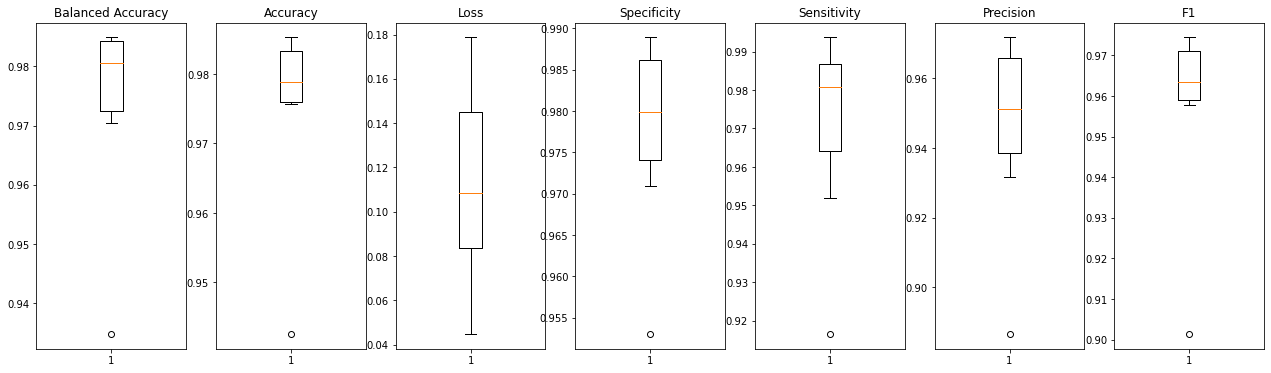

In [ ]:
fig, axes = plt.subplots(1, 7, figsize=(22,6))
axes[0].set_title('Balanced Accuracy')
axes[0].boxplot(df.bac)

axes[1].set_title('Accuracy')
axes[1].boxplot(df.accuracy)

axes[2].set_title('Loss')
axes[2].boxplot(df.loss)

axes[3].set_title('Specificity')
axes[3].boxplot(df.specificity)

axes[4].set_title('Sensitivity')
axes[4].boxplot(df.sensitivity)

axes[5].set_title('Precision')
axes[5].boxplot(df.precision)

axes[6].set_title('F1')
axes[6].boxplot(df.f1)

In [ ]:
pd.DataFrame(df.mean())

,0
loss,0.110916
bac,0.975225
accuracy,0.976401
f1,0.959356
recall,0.972476
precision,0.946853
sensitivity,0.972476
specificity,0.977975
